# Burgers Equation on FLRW Spacetimes
## A Numerical Approach

===== ===== ===== ===== =====

General Burgers: $u_{t} + u\cdot u_{x} - \alpha\cdot u_{xx} = 0$, *where $\alpha =$ diffusion coefficient, and $\alpha = 0$ for Inviscid Burgers*.  Thus,

$u_{t} + u\cdot u_{x} = 0$

On an FLRW background, via Ceylon et al.:

### $a\cdot u_{t}+(1-kr^{2})^{1/2}\cdot \partial_r(\frac{u^2}{2}) + u\cdot (1-\frac{u^{2}}{c^{2}})\cdot \dot{a} = 0$

===== ===== ===== ===== =====

## 1. Library Imports:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, clear_output

from godunov_burgers import  godunov_scheme as gb
from godunov_burgers import PDE_plotter_1D as Pplot

#### ----

## 2. Set Analysis Parameters

### 2a. Initial & Boundary Conditions

In [ ]:
# Boundary Condition Functions (Direchelet - time domain)
def u_t_0(t):
    return t

def u_t_L(t):
    return t

# Initial Condition Function - Step Function at x = .3
def u_0_x(x):
    if x < .3:
        return 0
    else:
        return 1

### 2b. Geometry and Temporal Parameters

Need t_max, L and dr.

In [ ]:
t_max = 1
L = 1
dr = .05

### 2c. k, c and alpha (Variance Parameters)

In [ ]:
k_vals = [-1,0,1]
alpha_vals = [-2,-1,-0.5, 0, 0.25, 0.5, 0.75, 1, 1.25, 2]
c = 1

## 3. Calculate U

In [ ]:
# Dictionary to store matrices
U_outputs = {}

# Generate and store matrices
for alpha in alpha_vals:
    for k in k_vals:
        U = gb(L, dr, k, c, alpha, t_max, u_0_x, u_t_0, u_t_L)
        U_outputs[(alpha, k)] = U
        print(f'Competed {alpha},{k}')

In [ ]:
steps = 20
t_min_plot = 0
t_max_plot = t_max
x_min_plot = 0
x_max_plot = L

Pplot(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, style = 'multi', alpha_decay = .7)

-----

## Function Builder 'Scrap' Work:

In [2]:
# Boundary Condition Functions (Direchelet - time domain)
def u_t_0(t):
    return t

def u_t_L(t):
    return t

# Initial Condition Function
def u_0_x(x):
    if x < .3:
        return 0
    else:
        return 1

# FLRW Acceleration Terms - First Order
def a_scale(t, alpha, a0=1, t0=1):
    return 1 + t**alpha

def a_scale_t(t, alpha, a0=1, t0=1):
    return alpha * t**(alpha - 1)

In [3]:
# Function to calculate the flux
def calculate_flux(u, r, k, a_t):
    return (1 - k * r**2)**0.5 * u**2 / (2 * a_t)

# Function to calculate wave speeds
def calculate_wave_speeds(u, r, k, c, a, a_t):
    wave_speed_1 = abs((1 - k * r**2)**0.5 * u / a)
    wave_speed_2 = abs(u * (1 - (u**2 / c**2)) * a_t / a)
    return wave_speed_1, wave_speed_2

# Precompute the maximum wave speeds over the domain and time interval
def precompute_max_wave_speed(u_initial, r, k, c, a_scale, a_scale_t, alpha, t_max):
    max_speed = 0
    t_values = np.linspace(0, t_max, 100)  # Discretize the time interval

    for t in t_values:
        a = a_scale(t,alpha)
        a_t = a_scale_t(t,alpha)
        for i in range(len(u_initial)):
            wave_speed_1, wave_speed_2 = calculate_wave_speeds(u_initial[i], r[i], k, c, a, a_t)
            max_speed = max(max_speed, wave_speed_1, wave_speed_2)

    return max_speed

In [4]:
L = 1
dr = .05
Nr = int(L/dr)
r_grid = np.linspace(0,L,Nr+1)

In [5]:
# Using Initial Conditions, Create u0 (needs u_0_x)
u0 = [u_0_x(x) for x in r_grid]

# Set the boundary conditions
u0[0] = u_t_0(0)
u0[-1] = u_t_L(1)

u0

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [6]:
# Define the HLL flux calculation with correct r interface handling
def hll_flux(u_left, u_right, r_left, r_right, k, a, a_t):
    r_interface = (r_left + r_right) / 2
    f_left = calculate_flux(u_left, r_interface, k, a_t)
    f_right = calculate_flux(u_right, r_interface, k, a_t)
    s_left, s_right = calculate_wave_speeds(u_left, r_interface, k, c, a, a_t)
                      
    if s_left >= 0:
        return f_left
    elif s_right <= 0:
        return f_right
    else:
        return (s_right * f_left - s_left * f_right + s_left * s_right * (u_right - u_left)) / (s_right - s_left)

# Godunov scheme implementation with time-dependent a and a_dot
def godunov_scheme(u0, r, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max):
    U = []
    U.append(u0)
    u = u0.copy()
    t = 0
    while t < t_max:
        t += dt
        u_new = u.copy()

        for i in range(1, len(u) - 1):
            r_left = r[i - 1]
            r_center = r[i]
            r_right = r[i + 1]

            F_i_plus_1_2 = hll_flux(u[i], u[i + 1], r_center, r_right, k, a_scale(t, alpha), a_scale_t(t,alpha))
            F_i_minus_1_2 = hll_flux(u[i - 1], u[i], r_left, r_center, k, a_scale(t, alpha), a_scale_t(t,alpha))

            source_term = u[i] * (1 - (u[i]**2 / c**2)) * a_scale_t(t, alpha) / a_scale(t, alpha)
            u_new[i] = u[i] - (dt / dr) * (F_i_plus_1_2 - F_i_minus_1_2) - dt * source_term
                
        u = u_new.copy()
        
        U.append(u)
    
    return U

In [67]:
k = 1
c = 1
alpha = 2
t_max = 1

max_speed = precompute_max_wave_speed(u0, r_grid, k, c, a_scale, a_scale_t, alpha, t_max)
dt = dr / max_speed

In [68]:
U30 = godunov_scheme(u0, r_grid, k, a_scale, a_scale_t, alpha, c, dr, dt, t_max)

/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_294/2933101424.py:3: RuntimeWarning: overflow encountered in scalar power
  return (1 - k * r**2)**0.5 * u**2 / (2 * a_t)
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_294/2933101424.py:8: RuntimeWarning: overflow encountered in scalar power
  wave_speed_2 = abs(u * (1 - (u**2 / c**2)) * a_t / a)
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_294/2152037774.py:33: RuntimeWarning: overflow encountered in scalar power
  source_term = u[i] * (1 - (u[i]**2 / c**2)) * a_scale_t(t, alpha) / a_scale(t, alpha)
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_294/2152037774.py:34: RuntimeWarning: invalid value encountered in scalar subtract
  u_new[i] = u[i] - (dt / dr) * (F_i_plus_1_2 - F_i_minus_1_2) - dt * source_term
/var/folders/nw/8yyyyp8n70vbplhdsylyqs8c0000gn/T/ipykernel_294/2933101424.py:8: RuntimeWarning: overflow encountered in scalar multiply
  wave_speed_2 = abs(u * (1 - (u**2 / c**2)) * a

Un = {k,alpha}
U1 = {-1,-2}
U2 = {0,-2}
U3 = {1,-2}
U4 = {-1,-1}
U5 = {0,-1}
U6 = {1,-1}
U7 = {-1,-0.5}
U8 = {0,-0.5}
U9 = {1,-0.5}
U10 = {-1,0}
U11 = {0,0}
U12 = {1,0}
U13 = {-1,.2}
U14 = {0,.2}
U15 = {1,.2}
U16 = {-1,.5}
U17 = {0,.5}
U18 = {1,.5}
U19 = {-1,.8}
U20 = {0,.8}
U21 = {1,.8}
U22 = {-1,1}
U23 = {0,1}
U24 = {1,1}
U25 = {-1,1.2}
U26 = {0,1.2}
U27 = {1,1.2}
U28 = {-1,2}
U29 = {0,2}
U30 = {1,2}

In [75]:
U_master = [U1, U2, U3, U4, U5, U6, U7, U8, U9, U10, U11, U12, U13, U14, U15, U16, U17, U18, U19, U20, U21, U22, U23, U24, U25, U26, U27, U28, U29, U30]

In [157]:
U_index = []

k_vals = [-1,0,1]
alphas = [-2, -1, -.5, 0, .2, .5, .8, 1, 1.2, 2]

counter = 1

for alpha in alphas:
    for k in k_vals:
        U_index.append(f'U{counter}: alpha = {alpha}, k = {k}')
        counter +=1

In [114]:
U_dict = {}

k_vals = [-1,0,1]
alphas = [-2, -1, -.5, 0, .2, .5, .8, 1, 1.2, 2]

counter = 0

for alpha in alphas:
    for k in k_vals:
        U_dict[(k, alpha)] = U_master[counter]
        counter += 1

In [115]:
U_dict

{(-1, -2): [[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.00013143588028,
   1.0000020641782406,
   1.000002320652805,
   1.0000025642250836,
   1.0000027945260668,
   1.0000030114374623,
   1.0000032150552502,
   1.0000034056512117,
   1.0000035836351877,
   1.0000037495200231,
   1.0000039038904198,
   1.0000040473762932,
   1.000004180630749,
   1.0000043043124704,
   1],
  [0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0009254311224234,
   1.0000142581679943,
   1.0000163361937862,
   1.0000180507486132,
   1.0000196718836298,
   1.0000211987662266,
   1.0000226320720915,
   1.0000239737144159,
   1.0000252265782097,
   1.000026394273546,
   1.0000274809163097,
   1.00002849094064,
   1.0000294289439142,
   1.0000302995627668,
   1],
  [0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0032983582571686,
   1.0000453298180758,
   1.0000581667082404,
   1.0000642680188558,
   1.000070038737984,
   1.000075473938084

In [128]:
np.linspace(0, L, 21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

U1: alpha = -2, k = -1


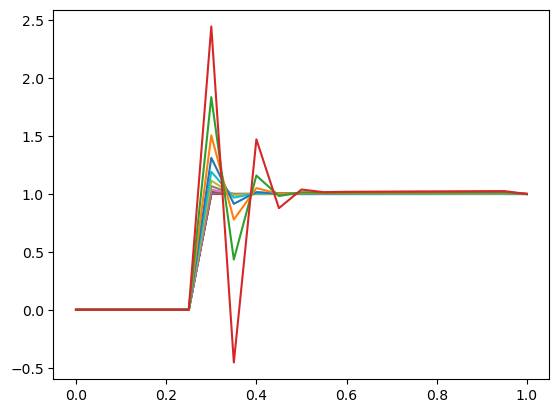

----

U2: alpha = -2, k = 0


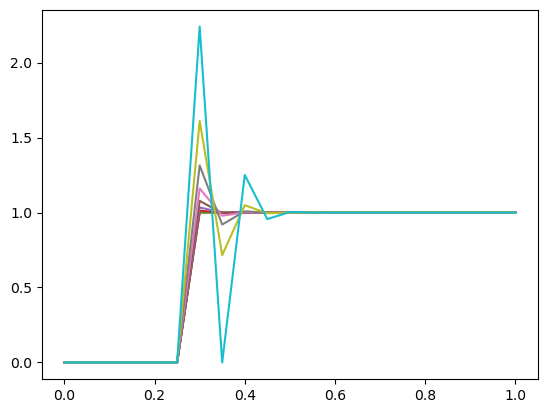

----

U3: alpha = -2, k = 1


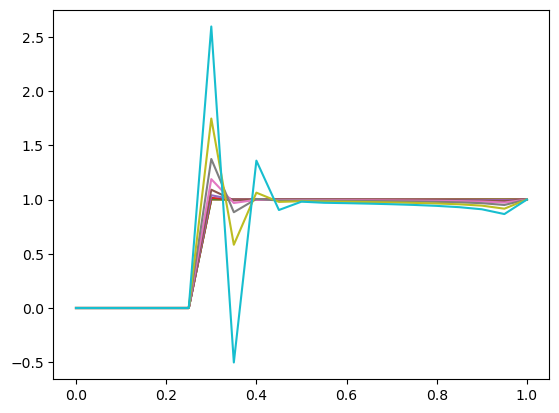

----

U4: alpha = -1, k = -1


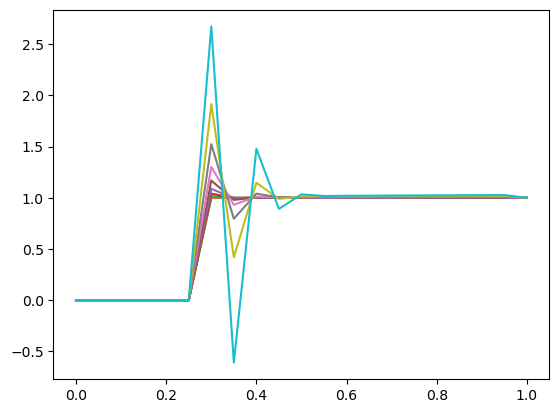

----

U5: alpha = -1, k = 0


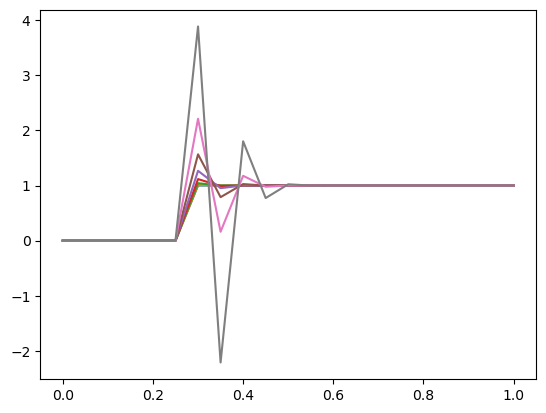

----

U6: alpha = -1, k = 1


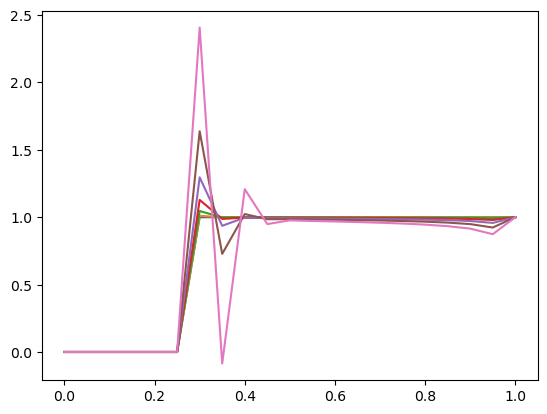

----

U7: alpha = -0.5, k = -1


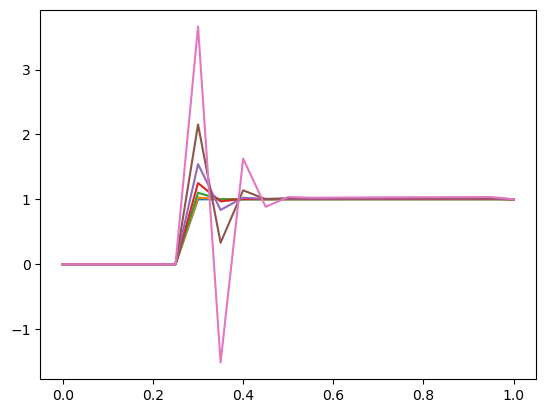

----

U8: alpha = -0.5, k = 0


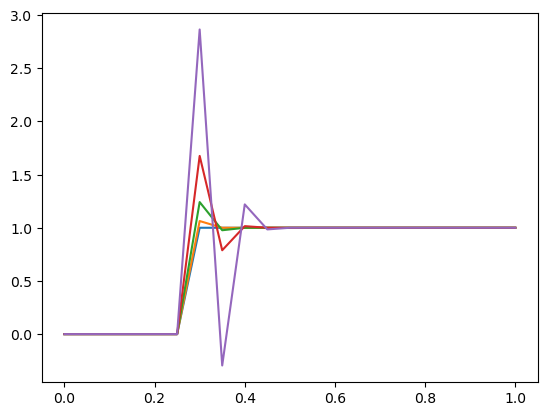

----

U9: alpha = -0.5, k = 1


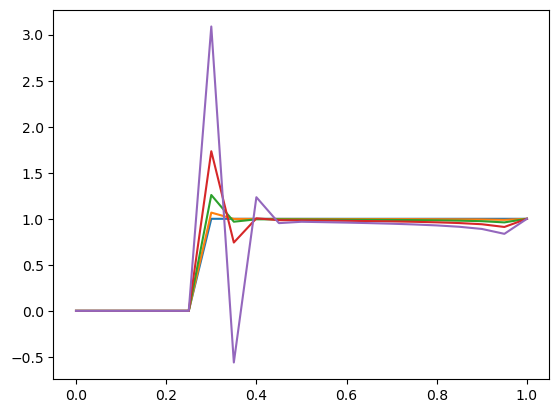

----

U10: alpha = 0, k = -1


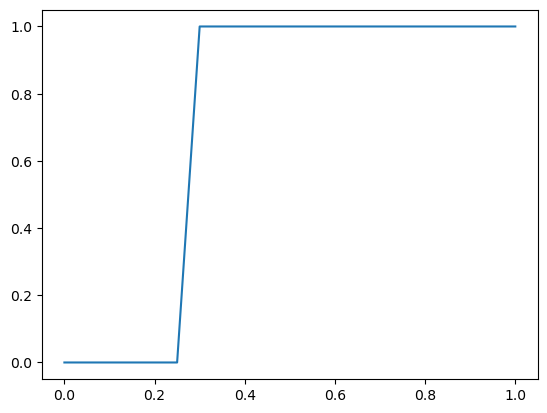

----

U11: alpha = 0, k = 0


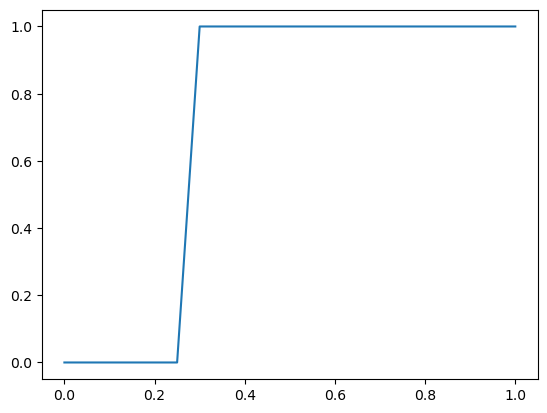

----

U12: alpha = 0, k = 1


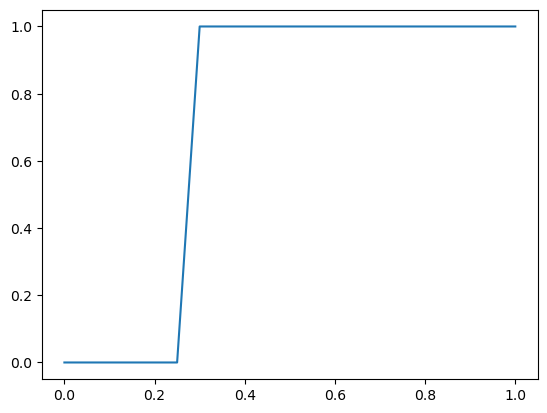

----

U13: alpha = 0.2, k = -1


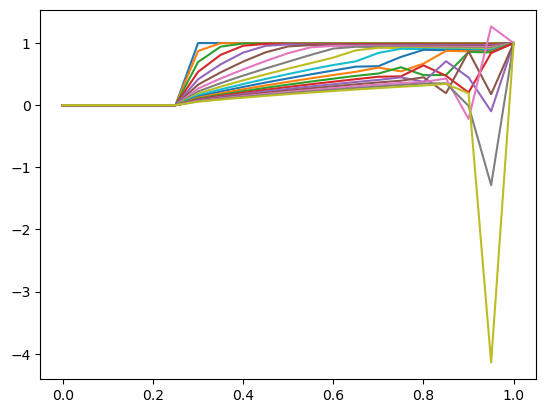

----

U14: alpha = 0.2, k = 0


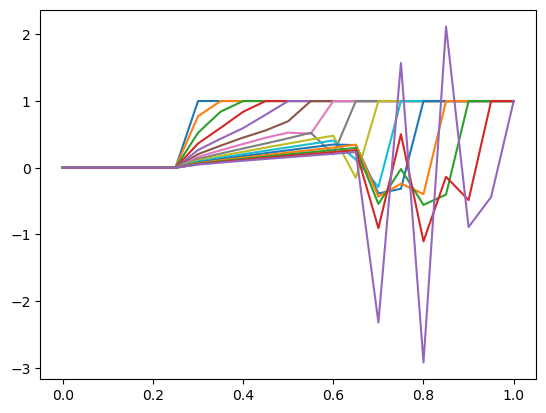

----

U15: alpha = 0.2, k = 1


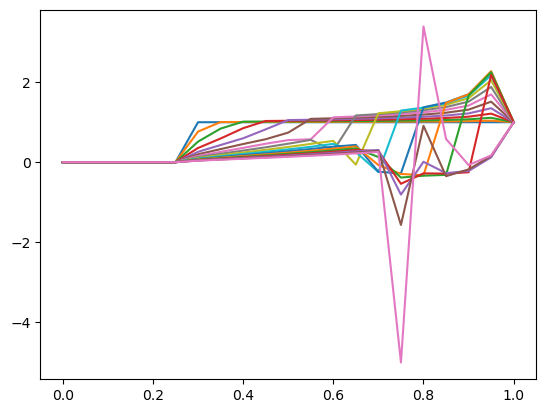

----

U16: alpha = 0.5, k = -1


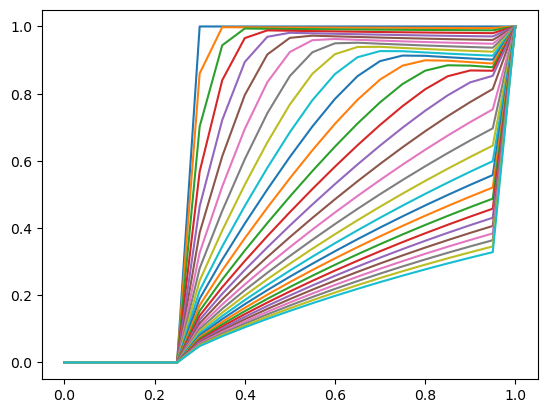

----

U17: alpha = 0.5, k = 0


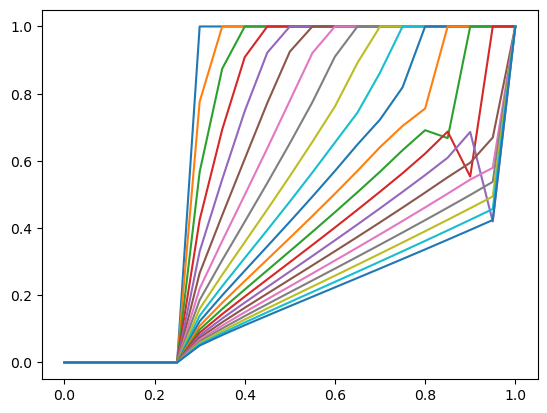

----

U18: alpha = 0.5, k = 1


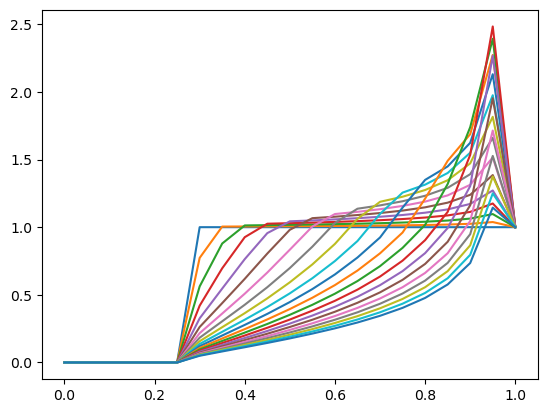

----

U19: alpha = 0.8, k = -1


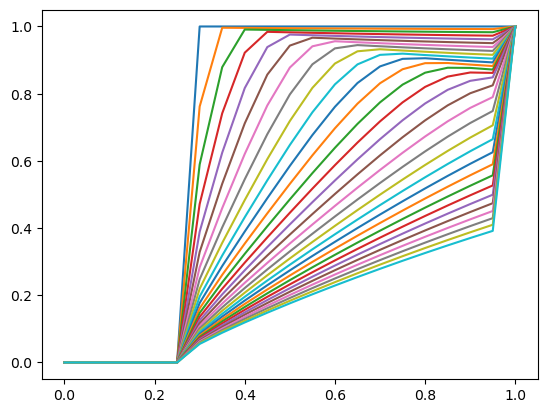

----

U20: alpha = 0.8, k = 0


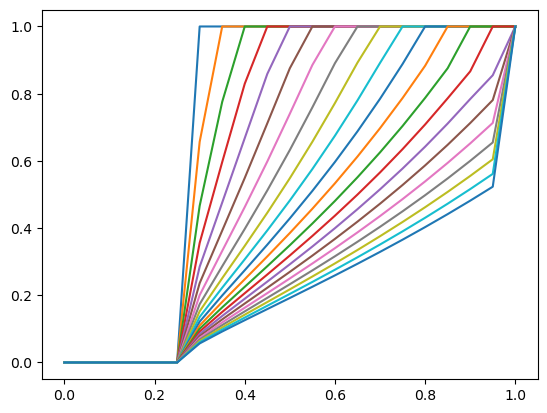

----

U21: alpha = 0.8, k = 1


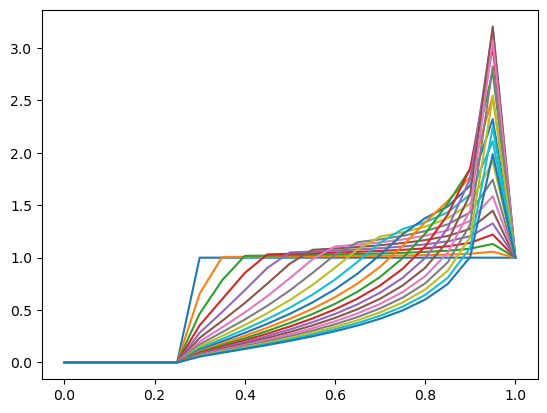

----

U22: alpha = 1, k = -1


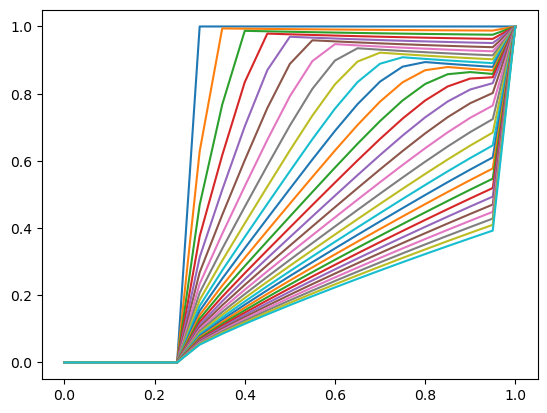

----

U23: alpha = 1, k = 0


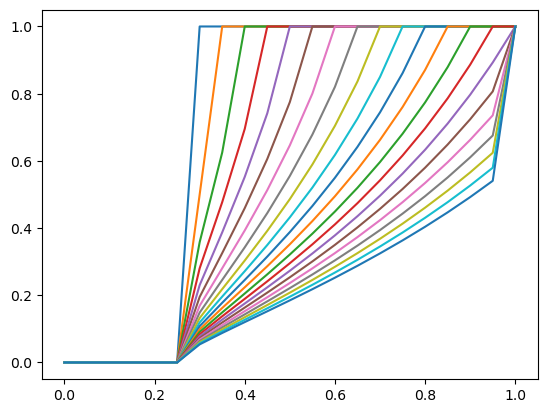

----

U24: alpha = 1, k = 1


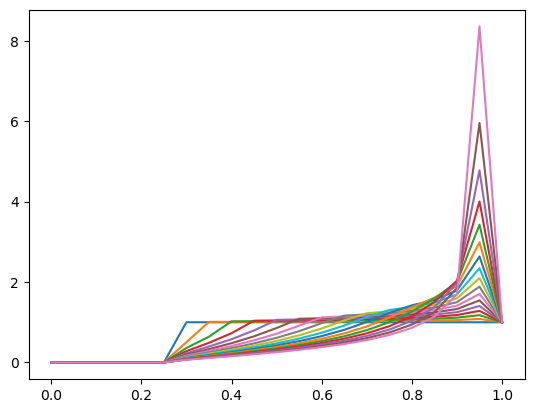

----

U25: alpha = 1.2, k = -1


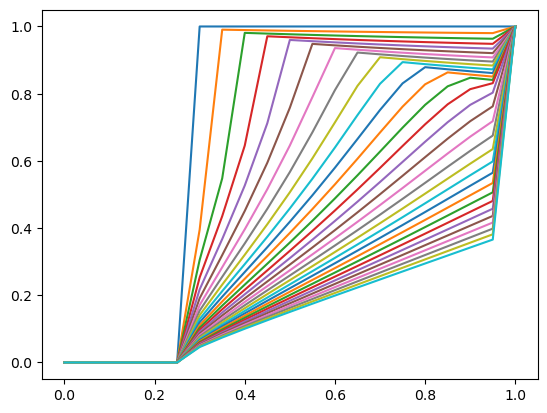

----

U26: alpha = 1.2, k = 0


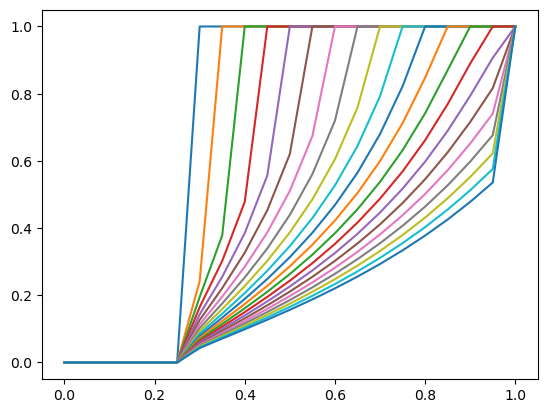

----

U27: alpha = 1.2, k = 1


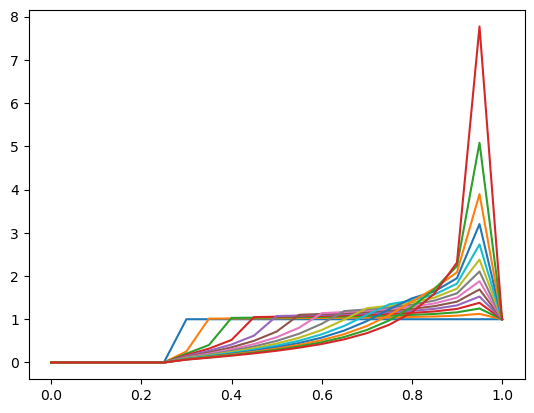

----

U28: alpha = 2, k = -1


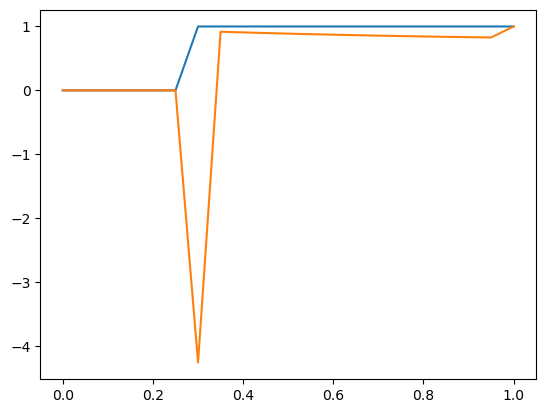

----

U29: alpha = 2, k = 0


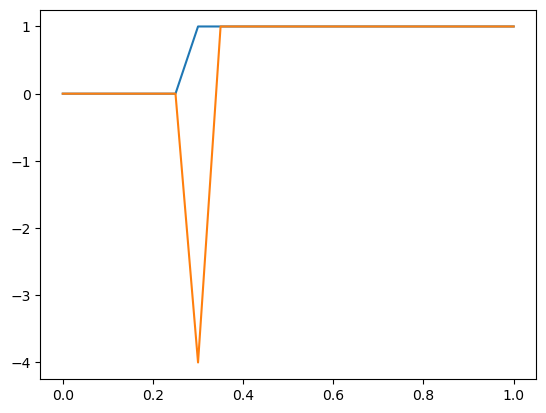

----

U30: alpha = 2, k = 1


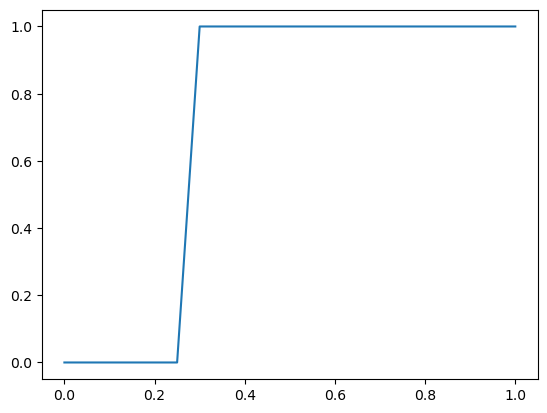

----



In [159]:
counter = 0

x_values = np.linspace(0, L, 21)

for U in U_master:
    for i in np.arange(0,len(U)):
        k = [abs(x) for x in U[i]]
        if sum(k) > 20:
            break
        else:
            plt.plot(x_values,U[i])
    print(U_index[counter])
    plt.show()
    print('----\n')
    counter += 1

In [151]:
pd.DataFrame(U4)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1
1,0,0.0,0.0,0.0,0.0,0.0,1.003718e+00,1.000058e+00,1.000066e+00,1.000073e+00,...,1.000085e+00,1.000091,1.000096,1.000101,1.000106,1.000110,1.000114,1.000118,1.000122,1
2,0,0.0,0.0,0.0,0.0,0.0,1.015423e+00,1.000132e+00,1.000271e+00,1.000299e+00,...,1.000352e+00,1.000375,1.000397,1.000418,1.000438,1.000456,1.000472,1.000488,1.000502,1
3,0,0.0,0.0,0.0,0.0,0.0,1.041242e+00,9.995536e-01,1.000722e+00,1.000790e+00,...,1.000927e+00,1.000990,1.001048,1.001103,1.001154,1.001201,1.001245,1.001286,1.001324,1
4,0,0.0,0.0,0.0,0.0,0.0,1.088648e+00,9.956004e-01,1.001633e+00,1.001652e+00,...,1.001939e+00,1.002069,1.002191,1.002305,1.002411,1.002510,1.002602,1.002687,1.002766,1
5,0,0.0,0.0,0.0,0.0,0.0,1.169011e+00,9.803147e-01,1.003933e+00,1.002985e+00,...,1.003530e+00,1.003765,1.003986,1.004192,1.004383,1.004562,1.004728,1.004882,1.005025,1
6,0,0.0,0.0,0.0,0.0,0.0,1.301757e+00,9.325280e-01,1.011760e+00,1.004647e+00,...,1.005860e+00,1.006247,1.006609,1.006947,1.007263,1.007556,1.007829,1.008082,1.008317,1
7,0,0.0,0.0,0.0,0.0,0.0,1.524041e+00,7.963591e-01,1.041267e+00,1.004640e+00,...,1.009112e+00,1.009709,1.010265,1.010784,1.011268,1.011718,1.012136,1.012524,1.012884,1
8,0,0.0,0.0,0.0,0.0,0.0,1.915729e+00,4.202481e-01,1.147578e+00,9.901552e-01,...,1.013436e+00,1.014384,1.015192,1.015948,1.016652,1.017308,1.017916,1.018481,1.019006,1
9,0,0.0,0.0,0.0,0.0,0.0,2.673545e+00,-6.073669e-01,1.478656e+00,8.925149e-01,...,1.018032e+00,1.020603,1.021677,1.022735,1.023719,1.024635,1.025485,1.026275,1.027007,1


In [ ]:
steps = 20
t_min_plot = 0
t_max_plot = t_max
x_min_plot = 0
x_max_plot = L

Pplot(U, L, t_max, steps, t_min_plot, t_max_plot, x_min_plot, x_max_plot, style = 'multi', alpha_decay = .7)